In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt

# Part 1: Bayesian MLR

In [2]:
#Dataset can be found here: https://www.kaggle.com/datasets/yakhyojon/national-basketball-association-nba
url = 'https://raw.githubusercontent.com/juliacmurray/STA365/main/STA365%20nba-players.csv'
df = pd.read_csv(url, index_col=0)

In [3]:
n,p=1340,4
X = df.filter(items=['min','ft', 'reb', 'tov']) #predict based on average 3-pointers made per game, free-throw percentage, rebounds per game, and tunrovers per game
Y = df.filter(items=['gp']) #looking to predict number of games played in an NBA career

In [4]:
X

,min,ft,reb,tov
0,27.4,69.9,4.1,1.3
1,26.9,76.5,2.4,1.6
2,15.3,67.0,2.2,1.0
3,11.6,68.9,1.9,1.0
4,11.5,67.4,2.5,0.8
...,...,...,...,...
1335,15.8,79.2,1.2,0.8
1336,12.6,79.4,1.5,1.3
1337,12.1,64.3,3.8,0.9
1338,12.0,62.5,0.7,0.8


In [5]:
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=10, lower=0) # half normal
    Y = pm.Normal('Y', mu=pm.math.dot(X, betas), sigma=sigma, observed=Y)

with MLR:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Split-R-hats {'betas': array([[1.0005, 1.002 , 1.0006, 1.0015],
       [1.0026, 1.0022, 1.0019, 1.001 ],
       [1.0007, 1.0023, 1.0005, 1.0009],
       [1.0006, 1.0011, 1.0001, 1.0009]]), 'sigma': 0.9998} | 

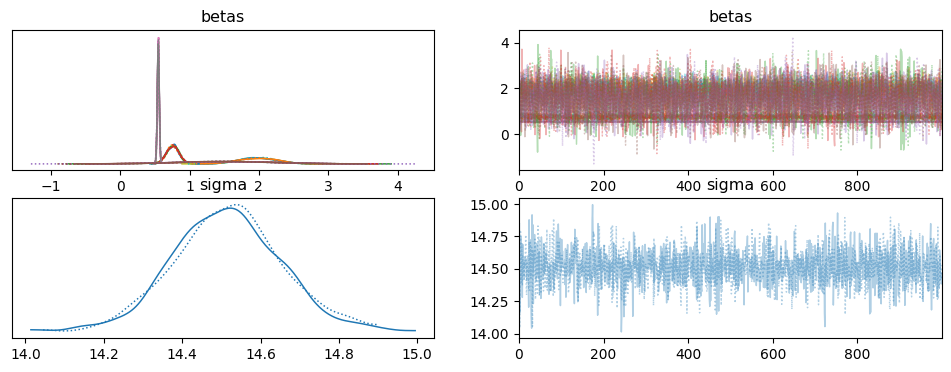

In [6]:
#A little bit of inference
az.plot_trace(idata)
print("Split-R-hats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()}, end=' | ')

# Part 2: probability of beta (with variance instead of covariance matrix)

1. $p(\beta | Σ, X, y) = MVN\left(E[\beta |Σ, X, y] = (X^T \frac{1}{σ^2} X)^{-1}X^T\frac{1}{σ^2}y, Var[\beta |Σ, X, y] = (X^T\frac{1}{σ^2}X)^{-1}\right)$

2. $E[\beta |Σ, X, y] = (X^T \frac{1}{σ^2} X)^{-1}X^T\frac{1}{σ^2}y$ if $Σ = σ^2I$

3. For $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$, we need $Σ = I$ so $σ^2 = 1$ if $Σ = σ^2I$

4. $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$ would also require $Σ = I$ so $σ^2 = 1$ if $Σ = σ^2I$

5. $Var[\beta |Σ, X, y] = (X^T\frac{1}{σ^2}X)^{-1}$ if  $Σ = σ^2I$


# Part 3: Bayesian Multivariate Normal Model

In [55]:
#Loading in the data
#Dataset can be found here: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009
url2 = 'https://raw.githubusercontent.com/juliacmurray/STA365/main/STA365%20wine%20data%20du.csv'
df2 = pd.read_csv(url2, index_col=0)
pH = df2.filter(items=['pH'])
volatile_acid = df2.filter(items=['volatile acidity'])
density = df2.filter(items=['density'])
fa = df2.filter(items=['fixed acidity'])

In [57]:
fa

,fixed acidity
index,
1,7.4
2,7.8
3,7.8
4,11.2
5,7.4
...,...
1595,6.2
1596,5.9
1597,6.3


Text(0.5, 1.0, 'Fixed Acidity Histogram')

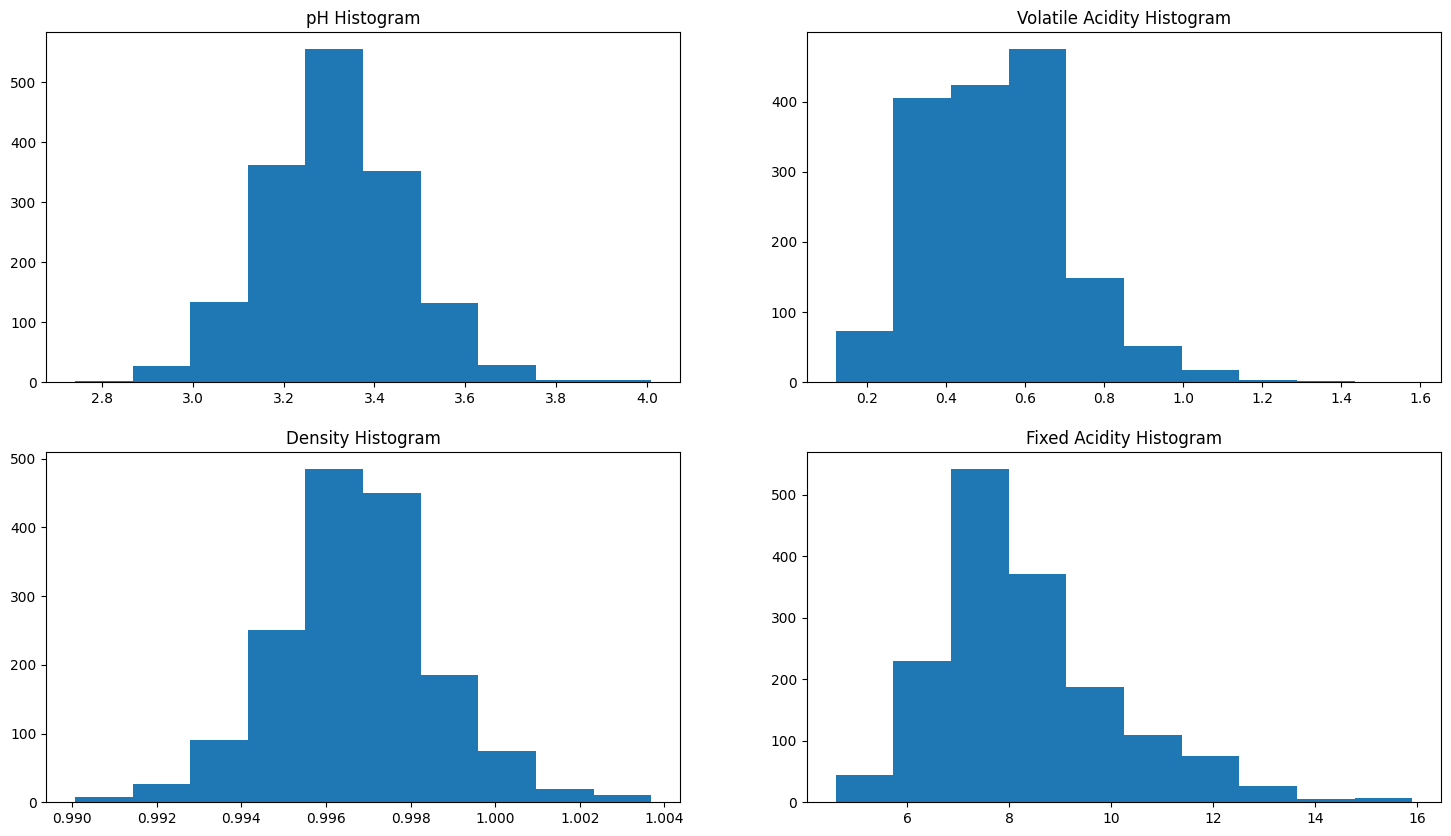

In [62]:
#Checking that the data looks normal enough to use (if marginals are normal, the data should be able to be modelled with MVN)

fig,ax = plt.subplots(2,2, figsize=(18,10))

ax[0,0].hist(pH)
ax[0,1].hist(volatile_acid)
ax[1,0].hist(density)
ax[1,1].hist(fa)

ax[0,0].set_title("pH Histogram")
ax[0,1].set_title("Volatile Acidity Histogram")
ax[1,0].set_title("Density Histogram")
ax[1,1].set_title("Fixed Acidity Histogram")
#All the components look pretty normal

In [74]:
(3.3+1+.05+8)/4

3.0875

In [86]:
y = np.array(df2.filter(items=['pH', 'volatile acidity', 'density', 'fixed acidity']))
n=len(y)
p= 4


with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta= 1.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=p), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = L.dot(L.T)
    mu = pm.MvNormal('mu', mu=np.array(3), cov=np.eye(p), shape=p);
    y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y)  #need to figure out how to matrix multiply here

with MNV_LKJ:
    idata2 = pm.sample()